# Analyzing Football Player Scores with Sorare Data

## Preparing Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from requests import get as get
from requests import post as post
import json
import bcrypt

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA


### API Authentication

Get player stats from Sorare, a Fantasy Football website that provides stats and scores for each player in major leagues through a GraphQL API. 

Authenticate

In [3]:
from password import password

In [4]:
email = "maite.marzoratti@gmail.com"

r = get(f'https://api.sorare.com/api/v1/users/{email}')
response = json.loads(r.content)
cookies={"_sorare_session_id":r.cookies['_sorare_session_id']}
# get salt and hash with password
salt = response['salt'].encode('utf8')
pwrd = password.encode('utf8')
hashed = bcrypt.hashpw(pwrd, salt).decode('utf8')
csrf = r.headers["CSRF-TOKEN"]

headers = {
    "x-csrf-token": csrf
}

# login
url = 'https://api.sorare.com/graphql'
login_query = """
mutation SignInMutation($input: signInInput!) {
  signIn(input: $input) {
    currentUser {
      slug
      __typename
    }
    otpSessionChallenge
    errors {
      path
      message
      __typename
    }
    __typename
  }
}
"""

variables = {
  "input": {
    "email": email,
    "password": hashed
  }
}

p = post(url, json={'query': login_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)


In [5]:
# # Write your query or mutation here
# player_query="""
# query {
#   player(slug: "rodrigo-javier-de-paul") {
#     id
#     displayName
#     activeClub {
#       name
#       slug
#     }
#     activeClub {
#       name
#     }
#     status {
#       lastFiveSo5AverageScore
#       lastFifteenSo5AverageScore
#     }
#   }
# }"""

# t=post(url, json={'query': player_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
#         headers=headers,cookies=cookies)
# t1=t.json()['data']['player']

# pd.json_normalize(t1)

### Sorare API Query

Query to get all players from Spains's La Liga

In [6]:
clubs_query="""
query{
    competition(slug:"primera-division-es") {
    clubs {
      nodes {
        slug
      }
    }
  }
}

"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

club_slugs=[]
for i in slugs:
    club_slugs.append(i['slug'])

And France's Ligue 1

In [7]:
clubs_query="""query{
    competition(slug:"ligue-1-fr") {
    clubs {
      nodes {
        slug
      }
    }
  }
}"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)
slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

for i in slugs:
    club_slugs.append(i['slug'])

In [8]:
len(club_slugs)

40

In [9]:
i=0

players_query="""
query playerQuery($club:String!){
  club(slug:$club) {
        name
        slug
        activePlayers {
          nodes {
            displayName
            slug
            status {
              lastFiveSo5Appearances
              lastFiveSo5AverageScore
              lastFifteenSo5Appearances
              lastFifteenSo5AverageScore
              playingStatus
            }
            lastClub {
              name
              activeCompetitions {
                name
              }
            }
            allSo5Scores (first:5) {
              nodes {
                position
                score
                detailedScore {
                  category
                  points
                  stat
                  statValue
                  totalScore
                }
              }
            }
       }
     }
   }

 }"""






In [10]:
player_df=pd.DataFrame()
for i in range(0,len(club_slugs)):
    variables = {
        "club":club_slugs[i]
        }
    active_players_r=post(url, json={'query': players_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

    player_df=player_df.append(pd.json_normalize(active_players_r.json()['data']))

In [11]:
club_df=player_df.reset_index(drop=True)

In [12]:
club_df.shape

(40, 3)

### Response Clean Up

Create a dataframe with the data provided in json by the API

In [13]:
club_df.head()

,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"[{'displayName': 'Arrasate', 'slug': 'jagoba-a..."
1,Real Madrid CF,real-madrid-madrid,"[{'displayName': 'Rodrygo', 'slug': 'rodrygo-s..."
2,Granada CF,granada-granada,"[{'displayName': 'Luis Suárez', 'slug': 'luis-..."
3,Cádiz CF,cadiz-cadiz,"[{'displayName': 'Álex', 'slug': 'alejandro-fe..."
4,Sevilla FC,sevilla-sevilla-1890,"[{'displayName': 'Antonio Zarzana', 'slug': 'a..."


Expand players in rows

In [14]:
club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)


,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Arrasate', 'slug': 'jagoba-ar..."
1,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Kike', 'slug': 'enrique-garci..."
2,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Sergio Herrera', 'slug': 'ser..."
3,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Roberto Torres', 'slug': 'rob..."
4,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Jonás Ramalho', 'slug': 'jona..."
...,...,...,...
1367,Stade Brestois 29,brest-brest,"{'displayName': 'Rafiki Said Ahamada', 'slug':..."
1368,Stade Brestois 29,brest-brest,"{'displayName': 'Franck Honorat', 'slug': 'fra..."
1369,Stade Brestois 29,brest-brest,"{'displayName': 'Romain Del Castillo', 'slug':..."
1370,Stade Brestois 29,brest-brest,"{'displayName': 'Gautier Larsonneur', 'slug': ..."


Expand json player data to columns

In [15]:
# laliga_data=laliga_r.json()['data']['competition']['clubs']['nodes']
# df_laliga=pd.json_normalize(laliga_data)
df_laliga_players=club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)
A=pd.json_normalize(df_laliga_players['club.activePlayers.nodes'])
df_laliga_players=df_laliga_players.drop(columns='club.activePlayers.nodes').join(A,how='left',rsuffix='_player',lsuffix='_club')
df_laliga_players.head()


,club.name,club.slug,displayName,slug,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",[]
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.800000,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Forward', 'score': 26.8, 'detai..."
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,58.600000,14,48.635714,starter,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Goalkeeper', 'score': 54.5, 'de..."
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,3,26.566667,12,28.525000,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Midfielder', 'score': 25.4, 'de..."
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,1,54.300000,1,54.300000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...","[{'position': 'Defender', 'score': 0.0, 'detai..."


In [16]:
df_laliga_players.shape

(1372, 12)

In [17]:
df_laliga_players.rename(columns={'slug':'slug_player','club.slug':'slug'},inplace=True)
pd.json_normalize(df_laliga_players[df_laliga_players.slug_player=='luka-modric']['allSo5Scores.nodes'])

,0,1,2,3,4
0,"{'position': 'Midfielder', 'score': 57.9, 'det...","{'position': 'Midfielder', 'score': 64.6, 'det...","{'position': 'Midfielder', 'score': 56.4, 'det...","{'position': 'Midfielder', 'score': 28.3, 'det...","{'position': 'Midfielder', 'score': 58.3, 'det..."


Expand player games to rows

In [18]:
df_laliga_player_scores=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
B=pd.json_normalize(df_laliga_player_scores['allSo5Scores.nodes'])
df_laliga_player_scores=df_laliga_player_scores.drop(columns='allSo5Scores.nodes').join(B,how='left')
df_laliga_player_scores.head()

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,score,detailedScore
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.0,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,26.8,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,34.4,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,63.9,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,5,42.8,13,43.953846,substitute,CA Osasuna,"[{'name': 'Club Friendlies'}, {'name': 'Copa d...",Forward,23.7,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


check individual player

In [19]:
df_laliga_player_scores[df_laliga_player_scores.slug_player=='luka-modric'][['slug_player','position','score']]

,slug_player,position,score
286,luka-modric,Midfielder,57.9
287,luka-modric,Midfielder,64.6
288,luka-modric,Midfielder,56.4
289,luka-modric,Midfielder,28.3
290,luka-modric,Midfielder,58.3


Add detailed score

Sorare uses it's own system to calculate each player's score from different stats:  https://draftgym.com/sorare-new-scoring-system-explained. For the following analysis we will be using the stat value and not the calulated score, as the last has has some other transformations.

In [20]:
df_laliga_player_scores['detailedScore']

0                                                     NaN
1       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
2       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
4       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
                              ...                        
6644    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6645    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6646    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6647    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6648    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
Name: detailedScore, Length: 6649, dtype: object

In [21]:
df_laliga_player_scores['detailedScore'].iloc[8][8]

{'category': 'PASSING',
 'points': -0.2,
 'stat': 'missed_pass',
 'statValue': 21.0,
 'totalScore': -4.2}

add a new column for each individual stat

In [22]:
#detailed stats to columns
df_stats=pd.DataFrame()

for j_player in range(df_laliga_player_scores.shape[0]):
    if df_laliga_player_scores.iloc[j_player]['detailedScore']==df_laliga_player_scores.iloc[j_player]['detailedScore']:
        df_stat_i=pd.DataFrame()
        for i in range(len(df_laliga_player_scores.iloc[j_player]['detailedScore'])):
            index=df_laliga_player_scores.index[j_player]
            stat_name=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['stat']
            stat_value=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['statValue']
            df_stat_i=pd.concat([df_stat_i,pd.DataFrame(index=[index],columns=[stat_name],data=[stat_value])],axis=1)
        df_stats=df_stats.append(df_stat_i)
df_stats.head(10)

,level_score,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,...,effective_clearance,long_pass_own_to_opp_success,penalty_conceded,goal_assist,assist_penalty_won,red_card,last_man_tackle,error_lead_to_goal,clearance_off_line,own_goals
1,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,18.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


join to players data

In [23]:
df_laliga_player_scores_detailed=df_laliga_player_scores.join(df_stats,how='left')
df_laliga_player_scores_detailed.drop(columns='detailedScore',inplace=True)
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6649 entries, 0 to 6648
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          6649 non-null   object 
 1   slug                               6649 non-null   object 
 2   displayName                        6649 non-null   object 
 3   slug_player                        6649 non-null   object 
 4   status.lastFiveSo5Appearances      6649 non-null   int64  
 5   status.lastFiveSo5AverageScore     6649 non-null   float64
 6   status.lastFifteenSo5Appearances   6649 non-null   int64  
 7   status.lastFifteenSo5AverageScore  6649 non-null   float64
 8   status.playingStatus               6628 non-null   object 
 9   lastClub.name                      6649 non-null   object 
 10  lastClub.activeCompetitions        6649 non-null   object 
 11  position                           6604 non-null   objec

Fill missing values with 0

In [24]:
df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64']=df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64'].fillna(0)

In [25]:
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6649 entries, 0 to 6648
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          6649 non-null   object 
 1   slug                               6649 non-null   object 
 2   displayName                        6649 non-null   object 
 3   slug_player                        6649 non-null   object 
 4   status.lastFiveSo5Appearances      6649 non-null   int64  
 5   status.lastFiveSo5AverageScore     6649 non-null   float64
 6   status.lastFifteenSo5Appearances   6649 non-null   int64  
 7   status.lastFifteenSo5AverageScore  6649 non-null   float64
 8   status.playingStatus               6628 non-null   object 
 9   lastClub.name                      6649 non-null   object 
 10  lastClub.activeCompetitions        6649 non-null   object 
 11  position                           6604 non-null   objec

In [26]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='luka-modric']['position']

286    Midfielder
287    Midfielder
288    Midfielder
289    Midfielder
290    Midfielder
Name: position, dtype: object

In [27]:
#rename columns
df_laliga_player_scores_detailed.rename(columns={'slug':'slug_club','club.name':'name'},inplace=True)
df_laliga_player_scores_detailed[['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','level_score']].groupby(['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','displayName'])['level_score'].mean()

name           slug_club              displayName          slug_player                  status.lastFiveSo5Appearances  displayName        
AS Monaco FC   monaco-monaco          Aleksandr Golovin    aleksandr-golovin            2                              Aleksandr Golovin      0.0
                                      Alexander Nübel      alexander-nubel              5                              Alexander Nübel        0.0
                                      Aurélien Platret     aurelien-platret             0                              Aurélien Platret       0.0
                                      Aurélien Tchouaméni  aurelien-tchouameni          4                              Aurélien Tchouaméni    0.0
                                      Axel Disasi          axel-disasi                  5                              Axel Disasi            0.0
                                                                                                                                   

### Grouped stats by player

Create a new dataset with the mean stats by player

In [28]:
# df_laliga_player_scores_detailed.drop(columns=['lastClub.name','lastClub.activeCompetitions'])
df_laliga_player_scores_grouped=df_laliga_player_scores_detailed.groupby(['name','slug_club','displayName','slug_player',
'status.lastFiveSo5Appearances','status.lastFiveSo5AverageScore','status.lastFifteenSo5Appearances','status.lastFifteenSo5AverageScore',
'status.playingStatus','position']).mean().reset_index()

In [29]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1327 entries, 0 to 1326
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               1327 non-null   object 
 1   slug_club                          1327 non-null   object 
 2   displayName                        1327 non-null   object 
 3   slug_player                        1327 non-null   object 
 4   status.lastFiveSo5Appearances      1327 non-null   int64  
 5   status.lastFiveSo5AverageScore     1327 non-null   float64
 6   status.lastFifteenSo5Appearances   1327 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1327 non-null   float64
 8   status.playingStatus               1327 non-null   object 
 9   position                           1327 non-null   object 
 10  score                              1327 non-null   float64
 11  level_score                        1327 non-null   float

In [30]:
df_laliga_player_scores_grouped.to_csv('players_grouped.csv')

## Exploratory Analysis

status

In [31]:
df_laliga_player_scores_grouped['status.playingStatus'].value_counts()

not_playing    576
starter        421
substitute     243
regular         87
Name: status.playingStatus, dtype: int64

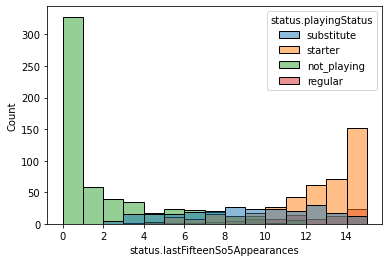

In [32]:
sns.histplot(data=df_laliga_player_scores_grouped,x='status.lastFifteenSo5Appearances',binwidth=1,hue='status.playingStatus');

Stats

In [33]:
stat_columns=df_laliga_player_scores_grouped.columns[12:]

Scale stats with min max scaler so that they can be compared. Visualize average stats by position to understand differences.

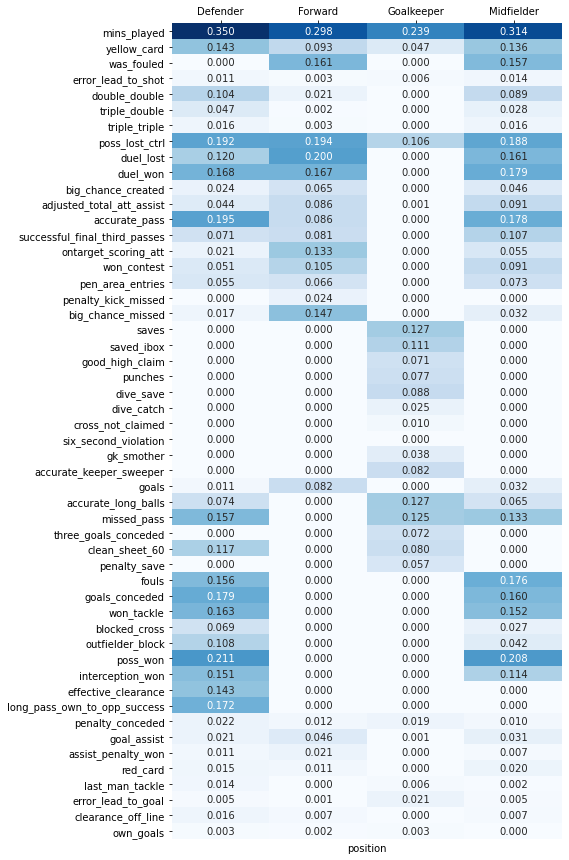

In [34]:
scaler_minmax=MinMaxScaler()
stats_scaled=scaler_minmax.fit_transform(df_laliga_player_scores_grouped[stat_columns])

df_stats_minmax=pd.DataFrame(data=stats_scaled,columns=stat_columns)
df_stats_minmax['position']=df_laliga_player_scores_grouped['position']

plt.figure(figsize=(7,15))
sns.heatmap(df_stats_minmax.groupby('position')[stat_columns].mean().T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


## Clustering

Identify different groups of players by making clusters with stats.

### PCA

Reducing dimensionality with PCA

In [35]:
mask_starter=df_laliga_player_scores_grouped['status.playingStatus']=='starter'
mask_regular=df_laliga_player_scores_grouped['status.playingStatus']=='regular'

X=df_laliga_player_scores_grouped[mask_starter|mask_regular]
X=X.iloc[:,12:]
print(X.shape)


scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

pca_df = PCA()
pca_df.fit(X_scaled)
pca_df.explained_variance_ratio_.round(2)

(508, 52)


array([0.18, 0.14, 0.08, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [36]:
pd.Series(pca_df.explained_variance_ratio_).cumsum()

0     0.183297
1     0.318338
2     0.400354
3     0.438587
4     0.468941
5     0.498717
6     0.524374
7     0.549625
8     0.573781
9     0.597575
10    0.619355
11    0.640317
12    0.660739
13    0.680567
14    0.700293
15    0.719413
16    0.738002
17    0.756375
18    0.773588
19    0.789514
20    0.804784
21    0.819952
22    0.834538
23    0.847900
24    0.860612
25    0.872974
26    0.883976
27    0.894426
28    0.903960
29    0.912716
30    0.921212
31    0.929155
32    0.936404
33    0.943025
34    0.949223
35    0.955042
36    0.960070
37    0.964775
38    0.969262
39    0.973463
40    0.977390
41    0.981132
42    0.984309
43    0.987458
44    0.990371
45    0.992889
46    0.995298
47    0.997405
48    0.998926
49    0.999859
50    1.000000
51    1.000000
dtype: float64

In [37]:
pca_loadings = pd.DataFrame(pca_df.components_.T, index=X.columns).iloc[:,:10]
pca_loadings.style.background_gradient(axis=None,cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
mins_played,-0.013456,-0.131029,0.325836,0.292503,0.135291,-0.063797,0.023566,0.086957,-0.007190,0.083256
yellow_card,-0.058087,-0.074390,0.032928,-0.047882,0.052107,-0.071340,0.030894,-0.287037,-0.065721,0.144966
was_fouled,-0.121528,0.189713,0.156642,-0.202106,0.189382,-0.185503,-0.042677,-0.029946,0.134786,-0.029266
error_lead_to_shot,0.003663,-0.024810,-0.047950,0.051240,0.152758,-0.054139,-0.267117,-0.054124,-0.229302,-0.333083
double_double,-0.115328,-0.162865,0.073695,-0.165882,0.139100,-0.136864,0.072700,-0.126377,0.086445,-0.034413
triple_double,-0.053408,-0.095575,0.032449,-0.046438,-0.015157,-0.044459,0.258965,0.251838,-0.081571,-0.370749
triple_triple,-0.027295,-0.034683,0.022069,-0.073102,0.037376,-0.086131,0.236034,0.059673,0.354399,-0.115622
poss_lost_ctrl,-0.093358,0.009885,0.375857,0.097386,-0.107067,-0.011178,0.129352,0.049639,-0.176047,0.196533
duel_lost,-0.207603,0.134087,0.127519,0.052245,0.108640,-0.145879,0.188689,0.013688,-0.072347,0.110700
duel_won,-0.233873,-0.015586,0.164237,-0.023633,0.165624,-0.197010,0.214530,-0.005528,0.091853,-0.016953


### Cluster

In [38]:
def Search_Kmeans(X_scaled):
    k_values=range(2,20)
    sq_distances=[] 
    sil=[]
    ch_scores=[]
    for k in k_values:
        kmeans=KMeans(n_clusters=k,n_init=10,random_state=0)
        kmeans.fit(X_scaled)
        sq_distances.append(kmeans.inertia_)
        score=silhouette_score(X_scaled,kmeans.labels_)
        sil.append(score)
        score=calinski_harabasz_score(X_scaled,kmeans.labels_)
        ch_scores.append(score)

    fig, axs = plt.subplots(1,3,figsize=(20,5))
    axs[0].set(xlabel = "Número de clusters", ylabel = "Suma Distancias Cuadráticas", title = "Inercia Score")
    axs[1].set(xlabel = "Número de clusters", ylabel = "Silhouette score", title = "Silhouette Score")
    axs[2].set(xlabel = "Número de clusters", ylabel = "Calinski-Harabasz Score", title = "Calinski-Harabasz Score")
    sns.lineplot(ax=axs[0],x=k_values,y=sq_distances,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[1],x=k_values,y=sil,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[2],x=k_values,y=ch_scores,marker='o',size=30,legend=False )
    axs[0].grid(color='gray', linewidth=1, ls='--')
    axs[1].grid(color='gray', linewidth=1, ls='--')
    axs[2].grid(color='gray', linewidth=1, ls='--')

In [39]:
X.shape

(508, 52)

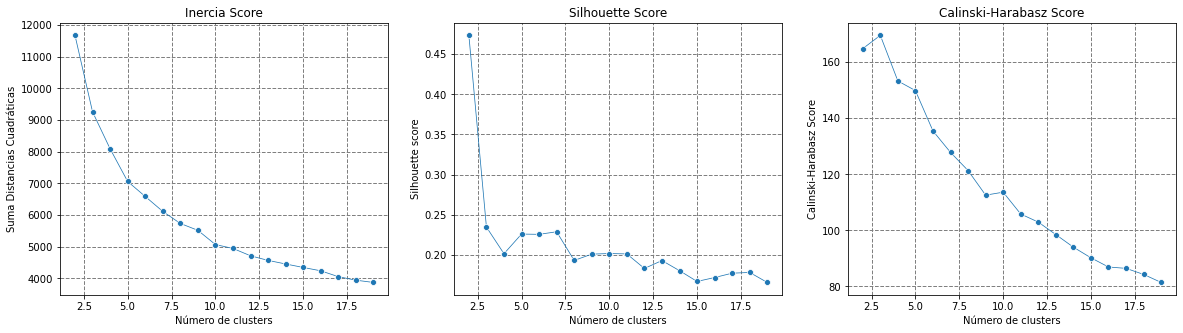

In [40]:
n_components=10
df_pca = pd.DataFrame(pca_df.transform(X_scaled)[:,:n_components], index=X.index)
df_pca.head(5)

Search_Kmeans(df_pca)

Clustering with 4 clusters, and calculate distance to each centroid

In [41]:
n_clusters=4
kmeans=KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(df_pca)

df_output=df_laliga_player_scores_grouped.loc[X.index]
df_output['label']=kmeans.labels_

dist_clusters=kmeans.transform(df_pca)
df_dist_clusters=pd.DataFrame(index=df_pca.index,data=dist_clusters)
dist_col_names=['dist_cluster_'+str(i) for i in df_dist_clusters.columns]
df_output[dist_col_names]=df_dist_clusters


### Cluster Analysis

Visualize which positions are included in each cluster

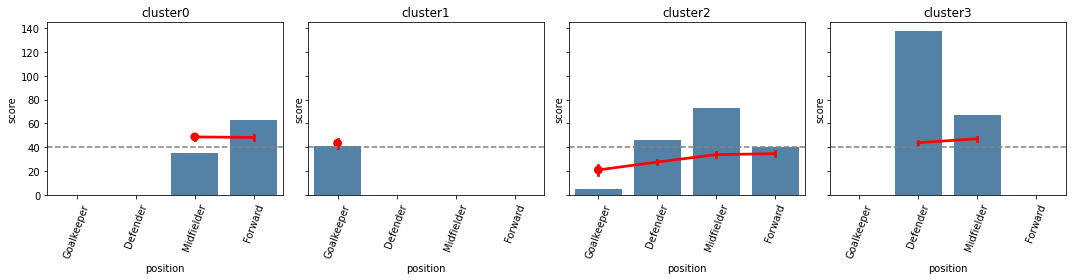

In [42]:

positions=['Goalkeeper','Defender','Midfielder','Forward']
labels=range(0,n_clusters)

n_plots=df_output['label'].nunique()
max_col=n_clusters
max_row=int(np.ceil(n_plots/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,4),squeeze=False,sharey=True)
for i in range(n_plots):
    df=df_output[df_output.label==i]
    sns.countplot(data=df,x='position',ax=ax[n_row,n_col],color='steelblue',order=positions)
    sns.pointplot(data=df,x='position',y='score',ax=ax[n_row,n_col],color='red',order=positions)
    ax[n_row,n_col].axhline(40, ls='--',color='gray')
    ax[n_row,n_col].set_xticklabels(ax[n_row,n_col].get_xticklabels(),rotation=70)

    ax[n_row,n_col].set_title('cluster'+str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

The clusters are mainly grouping by position. Something interesting is that there are players that seem to be "misclassified", for example defenders in the midfielders cluster(cluster0), or midfielders in the forwards cluster (cluster2). We will try to identify if these players have a playing style more similar than those in the other position and why.

Visualize how each position is distributed between clusters

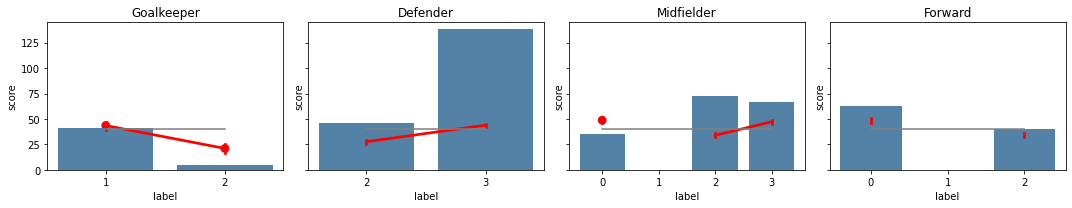

In [43]:


n_plots=df_output['label'].nunique()
max_col=4
max_row=int(np.ceil(len(positions)/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,3),squeeze=False,sharey=True)
for i in positions:
    df=df_output[df_output.position==i].copy()
    sns.countplot(data=df,x='label',ax=ax[n_row,n_col],color='steelblue',order=labels)
    sns.pointplot(data=df,x='label',y='score',ax=ax[n_row,n_col],color='red',order=labels)
    sns.lineplot(x=df.label,y=np.ones(df.label.shape[0])*40,ax=ax[n_row,n_col],color='gray')

    ax[n_row,n_col].set_title(str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

Give names to each cluster

In [44]:
df_output['label_name']=df_output.label.map({0:'Mid',1:'Goalkeeper',2:'Offensive',3:'Defensive'})

df_output.rename(columns={
    'dist_cluster_0':'dist_midfielder',
    'dist_cluster_1':'dist_goalkeeper',
    'dist_cluster_2':'dist_offensive',
    'dist_cluster_3':'dist_defensive',
},inplace=True)

dist_col_names=['dist_midfielder','dist_goalkeeper',
    'dist_offensive','dist_defensive']

In [45]:
df_output['label_name'].value_counts()

Defensive     205
Offensive     164
Mid            98
Goalkeeper     41
Name: label_name, dtype: int64

Scale stats so that they can be compared, and visualize how stat values are distributed between clusters.

In [46]:
cluster_stats=df_output.groupby('label_name')[stat_columns].mean()
cluster_stats

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,effective_clearance,long_pass_own_to_opp_success,penalty_conceded,goal_assist,assist_penalty_won,red_card,last_man_tackle,error_lead_to_goal,clearance_off_line,own_goals
label_name,,,,,,,,,,,,,,,,,,,,,
Defensive,77.021463,0.200976,0.403902,0.009756,0.230244,0.042927,0.009756,10.387317,3.411707,4.248780,...,1.691707,2.910244,0.012683,0.044878,0.004878,0.009756,0.003902,0.007805,0.006829,0.002927
Goalkeeper,79.336585,0.078049,0.000000,0.009756,0.000000,0.000000,0.000000,8.824390,0.000000,0.000000,...,0.000000,0.000000,0.024390,0.004878,0.000000,0.000000,0.004878,0.034146,0.000000,0.004878
Mid,72.708163,0.114286,1.244898,0.002041,0.069388,0.002041,0.002041,12.400000,5.257143,4.459184,...,0.000000,0.000000,0.008163,0.148980,0.008163,0.006122,0.000000,0.004082,0.002041,0.000000
Offensive,49.606098,0.121951,0.457317,0.009756,0.078049,0.012195,0.002439,6.503659,2.765854,2.458537,...,0.370732,0.614634,0.012195,0.043902,0.003659,0.002439,0.001220,0.003659,0.001220,0.001220


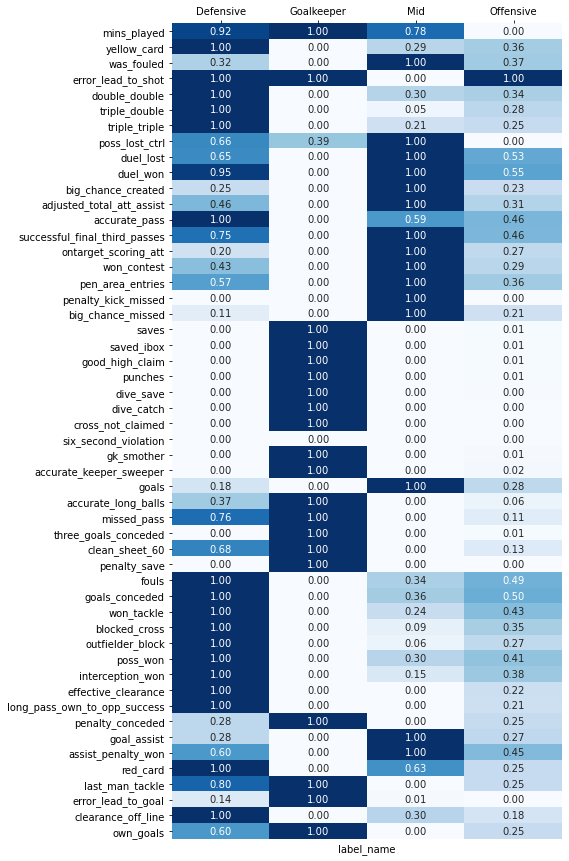

In [47]:
scaler=MinMaxScaler()
cluster_scaled=scaler.fit_transform(cluster_stats)

df_cluster_scaled=pd.DataFrame(data=cluster_scaled,columns=stat_columns,index=cluster_stats.index)

plt.figure(figsize=(7,15))
sns.heatmap(df_cluster_scaled.T,annot=True,cbar=False,fmt='.2f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


Visualize how each PCA component is included in each cluster

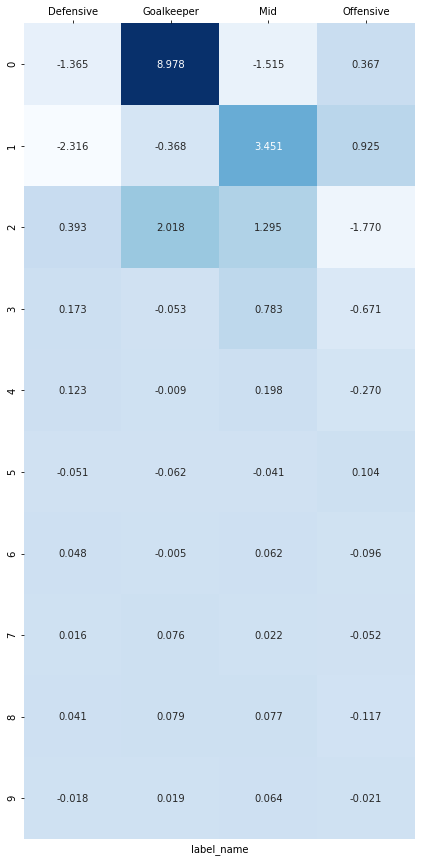

In [48]:
output_pca=df_pca.copy()
output_pca['label_name']=df_output['label_name']
cluster_pca=output_pca.groupby('label_name').mean()

plt.figure(figsize=(7,15))
sns.heatmap(cluster_pca.T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')

In [49]:
df_output.slug_club.unique()

array(['monaco-monaco', 'saint-etienne-saint-etienne',
       'angers-sco-angers', 'athletic-club-bilbao',
       'osasuna-pamplona-irunea', 'clermont-clermont-ferrand',
       'atletico-madrid-madrid', 'cadiz-cadiz',
       'deportivo-alaves-vitoria-gasteiz', 'elche-elche', 'troyes-troyes',
       'barcelona-barcelona', 'bordeaux-le-haillan', 'lorient-ploemeur',
       'metz-metz', 'nantes-la-chapelle-sur-erdre',
       'getafe-getafe-madrid', 'granada-granada', 'levante-valencia',
       'lille-villeneuve-d-ascq', 'montpellier-montpellier', 'nice-nice',
       'olympique-lyonnais-lyon', 'olympique-marseille-marseille',
       'psg-paris', 'strasbourg-strasbourg', 'lens-avion',
       'rayo-vallecano-madrid', 'real-betis-sevilla',
       'celta-de-vigo-vigo', 'mallorca-palma-de-mallorca',
       'real-madrid-madrid', 'real-sociedad-donostia-san-sebastian',
       'espanyol-barcelona', 'sevilla-sevilla-1890', 'brest-brest',
       'rennes-rennes', 'reims-reims', 'valencia-valencia',
  

Check how players in best known clubs (Barcelona, Atletico de Madrid and Real Madrid) are being classified.

In [50]:
col_names=['label_name','slug_player','score','position','slug_club','mins_played','dist_midfielder','dist_offensive',
    'dist_goalkeeper','dist_defensive']
df_output_dists=df_output[col_names].sort_values(by='label_name')
df_output_dists[df_output_dists.slug_club.isin(['psg-paris','real-madrid-madrid','atletico-madrid-madrid','barcelona-barcelona'])][col_names].sort_values(by='label_name')

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_goalkeeper,dist_defensive
384,Defensive,jordi-alba-ramos,60.92,Defender,barcelona-barcelona,68.4,6.728874,6.653915,12.202649,4.770436
212,Defensive,hector-miguel-herrera-lopez,43.14,Midfielder,atletico-madrid-madrid,56.6,5.367768,4.778620,11.360625,3.420356
829,Defensive,nuno-mendes,47.08,Defender,psg-paris,56.6,5.215140,3.194464,10.495782,3.081559
825,Defensive,marcos-aoas-correa,55.02,Defender,psg-paris,90.0,7.809956,5.929887,10.900255,4.094912
210,Defensive,geoffrey-kondogbia,63.44,Midfielder,atletico-madrid-madrid,68.0,8.811754,8.410964,13.693169,7.144158
235,Defensive,sime-vrsaljko,41.36,Defender,atletico-madrid-madrid,62.2,6.786795,5.419605,11.290259,2.833099
231,Defensive,stefan-savic-1991-01-08,49.86,Defender,atletico-madrid-madrid,90.0,9.694669,8.423440,12.595557,4.596183
226,Defensive,reinildo-isnard-mandava,42.28,Defender,atletico-madrid-madrid,87.6,7.957380,6.363093,11.677621,2.922061
222,Defensive,marcos-llorente-moreno,44.96,Midfielder,atletico-madrid-madrid,83.0,4.932793,4.403799,11.146438,3.201060
824,Defensive,marco-verratti,54.84,Midfielder,psg-paris,72.0,7.084049,8.583018,14.334789,6.566259


Check players with biggest distance from all clusters. These are the most dis-similar players

In [51]:
df_output_dists['min_dist']=df_output_dists[dist_col_names].apply(min,axis=1)
mask_max=df_output_dists['min_dist']>df_output_dists['min_dist'].quantile(0.95)
df_output_dists[mask_max].sort_values(by='min_dist',ascending=False)

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_goalkeeper,dist_defensive,min_dist
130,Goalkeeper,unai-simon-mendibil,45.46,Goalkeeper,athletic-club-bilbao,90.0,25.428339,24.740701,21.193958,25.084849,21.193958
823,Mid,lionel-andres-messi-cuccittini,82.84,Forward,psg-paris,90.0,14.803736,18.371766,21.812673,18.319063,14.803736
83,Defensive,batista-mendy,33.34,Defender,angers-sco-angers,89.4,13.495549,12.605115,15.782784,11.020752,11.020752
68,Goalkeeper,paul-bernardoni,44.28,Goalkeeper,saint-etienne-saint-etienne,90.0,17.546368,16.617298,9.805752,17.133092,9.805752
682,Goalkeeper,jonas-omlin,60.88,Goalkeeper,montpellier-montpellier,85.8,19.458227,18.528057,9.776474,19.234171,9.776474
419,Goalkeeper,gaetan-poussin,40.44,Goalkeeper,bordeaux-le-haillan,90.0,18.443120,17.549170,8.668276,18.096096,8.668276
915,Goalkeeper,stole-dimitrievski,6.66,Goalkeeper,rayo-vallecano-madrid,36.0,11.318763,9.180133,8.618248,11.114188,8.618248
546,Goalkeeper,david-soria-solis,48.88,Goalkeeper,getafe-getafe-madrid,89.0,16.523634,15.570462,8.368870,15.825393,8.368870
249,Goalkeeper,jeremias-ledesma,50.88,Goalkeeper,cadiz-cadiz,90.0,14.905683,13.766308,8.153776,14.032197,8.153776
593,Goalkeeper,luis-manuel-arantes-maximiano,49.16,Goalkeeper,granada-granada,90.0,15.567697,14.662862,7.814454,14.851247,7.814454


Using distance to each cluster as a proxy for similarity with a position, we can visualize how each player's playing style resembles the one of defenders, midfielders and forwards. We can also understand which players are more different than everyone else by looking at players with larger distances to cluster centroids. For example Lionel Messi is one of the players most separeted from the rest. This means that his stats are far away from the others.

In [52]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_defensive',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Offensive and defensive similarity')

In [53]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_midfielder',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Midfielder and offensive similarity')

In [54]:
metric='accurate_pass'
df_laliga_player_scores_grouped.sort_values(by=metric,ascending=False)[['slug_club','slug_player','position','score',metric]].head(20)

,slug_club,slug_player,position,score,accurate_pass
824,psg-paris,marco-verratti,Midfielder,54.84,72.4
1050,real-madrid-madrid,toni-kroos,Midfielder,50.70,70.0
731,olympique-lyonnais-lyon,castello-lukeba,Defender,51.14,69.8
760,olympique-lyonnais-lyon,thiago-henrique-mendes-ribeiro,Midfielder,51.68,69.4
871,lens-avion,facundo-axel-medina,Defender,54.36,66.6
830,psg-paris,presnel-kimpembe,Defender,63.34,65.6
397,barcelona-barcelona,gerard-pique-bernabeu,Defender,51.26,65.2
532,nantes-la-chapelle-sur-erdre,pedro-chirivella-burgos,Midfielder,59.80,64.4
825,psg-paris,marcos-aoas-correa,Defender,55.02,63.0
710,nice-nice,dante-bonfim-da-costa-santos,Defender,51.82,62.4


In [55]:
toni_kroos=df_laliga_player_scores_grouped[df_laliga_player_scores_grouped.slug_player=='toni-kroos']
toni_kroos.loc[483].iloc[3:]

KeyError: 483

In [ ]:
df_player_stats_scaled=pd.DataFrame(index=X.index,columns=X.columns,data=X_scaled)
df_player_stats_scaled=df_player_stats_scaled.join(df_output[['slug_club','slug_player','label_name','position','score']],how='left')

In [ ]:
df_player_stats_scaled

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,penalty_save,error_lead_to_goal,last_man_tackle,clearance_off_line,own_goals,slug_club,slug_player,label_name,position,score
0,-1.710737,0.402147,-0.505213,-0.246628,-0.717977,-0.3135,-0.126491,-0.824034,-0.273947,-0.697230,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,monaco-monaco,aleksandr-golovin,Offensive,Midfielder,34.18
1,-0.671293,-0.874670,-0.793905,-0.246628,-0.717977,-0.3135,-0.126491,-1.284045,-1.656380,-1.736529,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,monaco-monaco,alexander-nubel,Goalkeeper,Goalkeeper,37.24
2,-0.162869,0.402147,0.938252,-0.246628,1.732631,-0.3135,-0.126491,0.658221,0.318525,1.381367,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,monaco-monaco,aurelien-tchouameni,Mid,Midfielder,52.34
3,-0.671293,-0.874670,-0.793905,-0.246628,-0.717977,-0.3135,-0.126491,-0.721810,-0.471437,-0.489370,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,monaco-monaco,axel-disasi,Defensive,Defender,27.26
5,-1.631649,-0.874670,-0.793905,-0.246628,0.507327,-0.3135,-0.126491,-0.261799,-0.372692,-1.320809,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,monaco-monaco,caio-henrique-oliveira-silva,Defensive,Defender,32.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,-0.976347,0.402147,0.072173,-0.246628,-0.717977,-0.3135,-0.126491,-1.130708,0.219779,-0.177581,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,villarreal-villarreal,manuel-trigueros-munoz,Offensive,Midfielder,52.26
1283,-1.620350,-0.874670,-0.505213,-0.246628,-0.717977,-0.3135,-0.126491,-1.181820,-0.570183,-1.009020,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,villarreal-villarreal,moises-gomez-bordonado,Offensive,Midfielder,36.72
1287,1.362402,1.678964,-0.793905,3.139512,0.507327,-0.3135,-0.126491,0.095986,-0.965164,-0.281511,...,-0.077075,5.074275,-0.077075,-0.136617,-0.118203,villarreal-villarreal,pau-francisco-torres,Defensive,Defender,54.00
1288,-0.174167,0.402147,-0.793905,-0.246628,0.507327,-0.3135,-0.126491,0.453772,0.318525,-0.385441,...,-0.077075,-0.175688,-0.077075,-0.136617,-0.118203,villarreal-villarreal,pervis-josue-estupinan-tenorio,Defensive,Defender,29.62


In [ ]:
df_melted=pd.melt(df_player_stats_scaled,id_vars=['slug_club','slug_player','label_name','position','score'])
df_melted['position_avg']=df_melted.groupby('label_name')['value'].transform(lambda x:x.mean())
df_melted['name']='player'


avg_position=df_melted.groupby(['position','variable'])[['value']].mean().reset_index()
avg_position['label_name']=avg_position['position']+'_avg'
avg_position['name']='position_avg'


avg_cluster=df_melted.groupby(['label_name','variable'])[['value']].mean().reset_index()
avg_cluster['label_name']=avg_cluster['label_name']+'_cluster_avg'
avg_cluster['name']='cluster_avg'

df_melted=df_melted.append(avg_position)
df_melted.loc[df_melted.name.isnull(),'name']=df_melted.loc[df_melted.name.isnull(),'position']+'_avg'
df_melted

 
df_melted=df_melted.append(avg_cluster)
df_melted.loc[df_melted.name.isnull(),'name']=df_melted.loc[df_melted.name.isnull(),'label_name']+'_avg'
df_melted



,slug_club,slug_player,label_name,position,score,variable,value,position_avg,name
0,monaco-monaco,aleksandr-golovin,Offensive,Midfielder,34.18,mins_played,-1.710737,-0.159001,player
1,monaco-monaco,alexander-nubel,Goalkeeper,Goalkeeper,37.24,mins_played,-0.671293,0.083803,player
2,monaco-monaco,aurelien-tchouameni,Mid,Midfielder,52.34,mins_played,-0.162869,0.228217,player
3,monaco-monaco,axel-disasi,Defensive,Defender,27.26,mins_played,-0.671293,-0.051323,player
4,monaco-monaco,caio-henrique-oliveira-silva,Defensive,Defender,32.10,mins_played,-1.631649,-0.051323,player
...,...,...,...,...,...,...,...,...,...
203,NaN,NaN,Offensive_cluster_avg,NaN,NaN,triple_triple,-0.126491,NaN,cluster_avg
204,NaN,NaN,Offensive_cluster_avg,NaN,NaN,was_fouled,0.553328,NaN,cluster_avg
205,NaN,NaN,Offensive_cluster_avg,NaN,NaN,won_contest,0.419726,NaN,cluster_avg
206,NaN,NaN,Offensive_cluster_avg,NaN,NaN,won_tackle,-0.853774,NaN,cluster_avg


In [ ]:
player=['ivan-rakitic']
#avg_values=df_melted['name'][df_melted['name'].str.contains('avg')].unique()
avg_values=['Midfielder_avg','Forward_avg','Mid_cluster_avg','Offensive_cluster_avg']
plot_values=np.concatenate([player,avg_values])
px.scatter(df_melted[df_melted.label_name.isin(plot_values)|df_melted.slug_player.isin(player)],y='variable',x='value',color='name',height=1000,opacity=0.5,hover_data=['name','label_name','slug_player','slug_club'])

In [ ]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               1294 non-null   object 
 1   slug_club                          1294 non-null   object 
 2   displayName                        1294 non-null   object 
 3   slug_player                        1294 non-null   object 
 4   status.lastFiveSo5Appearances      1294 non-null   int64  
 5   status.lastFiveSo5AverageScore     1294 non-null   float64
 6   status.lastFifteenSo5Appearances   1294 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1294 non-null   float64
 8   status.playingStatus               1294 non-null   object 
 9   position                           1294 non-null   object 
 10  score                              1294 non-null   float64
 11  level_score                        1294 non-null   float